In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchinfo import summary
import numpy as np
import os
#from pytorchcv import train

In [2]:
if not os.path.exists('data_catsndogs/kagglecatsanddogs_3367a.zip'):
    !wget -P data -q https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip

In [3]:
import zipfile
if not os.path.exists('data/PetImages'):
    with zipfile.ZipFile('data/kagglecatsanddogs_3367a.zip', 'r') as zip_ref:
        zip_ref.extractall('data')

In [6]:
std_normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
trans = transforms.Compose([transforms.Resize(256),transforms.CenterCrop(224),
                           transforms.ToTensor(),std_normalize])
dataset = torchvision.datasets.ImageFolder('data/PetImages',transform=trans)
trainset, testset = torch.utils.data.random_split(dataset,[20000,len(dataset)-20000])

In [7]:
vgg = torchvision.models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /Users/edwardquarm/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100.0%


In [21]:
sample_image = dataset[0][0].unsqueeze(0)
res = vgg(sample_image)
print(res[0].argmax())

tensor(282)


In [22]:
import json, requests
class_map = json.loads(requests.get("https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json").text)
class_map = { int(k) : v for k,v in class_map.items() }
class_map[res[0].argmax().item()]

['n02123159', 'tiger_cat']

In [23]:
summary(vgg,input_size=(1,3,224,224))

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      --                        --
├─Sequential: 1-1                        [1, 512, 7, 7]            --
│    └─Conv2d: 2-1                       [1, 64, 224, 224]         1,792
│    └─ReLU: 2-2                         [1, 64, 224, 224]         --
│    └─Conv2d: 2-3                       [1, 64, 224, 224]         36,928
│    └─ReLU: 2-4                         [1, 64, 224, 224]         --
│    └─MaxPool2d: 2-5                    [1, 64, 112, 112]         --
│    └─Conv2d: 2-6                       [1, 128, 112, 112]        73,856
│    └─ReLU: 2-7                         [1, 128, 112, 112]        --
│    └─Conv2d: 2-8                       [1, 128, 112, 112]        147,584
│    └─ReLU: 2-9                         [1, 128, 112, 112]        --
│    └─MaxPool2d: 2-10                   [1, 128, 56, 56]          --
│    └─Conv2d: 2-11                      [1, 256, 56, 56]          29

In [24]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print('Doing computations on device = {}'.format(device))

vgg.to(device)
sample_image = sample_image.to(device)

vgg(sample_image).argmax()

Doing computations on device = cpu


tensor(282)

torch.Size([1, 512, 7, 7])


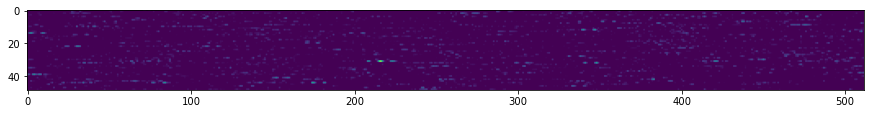

In [25]:
res = vgg.features(sample_image).cpu()
plt.figure(figsize=(15,3))
plt.imshow(res.detach().view(-1,512))
print(res.size())

In [26]:
bs = 8
dl = torch.utils.data.DataLoader(dataset,batch_size=bs,shuffle=True)
num = bs*100
feature_tensor = torch.zeros(num,512*7*7).to(device)
label_tensor = torch.zeros(num).to(device)
i = 0
for x,l in dl:
    with torch.no_grad():
        f = vgg.features(x.to(device))
        feature_tensor[i:i+bs] = f.view(bs,-1)
        label_tensor[i:i+bs] = l
        i+=bs
        print('.',end='')
        if i>=num:
            break

....................................................................................................

In [28]:
vgg_dataset = torch.utils.data.TensorDataset(feature_tensor,label_tensor.to(torch.long))
train_ds, test_ds = torch.utils.data.random_split(vgg_dataset,[700,100])

train_loader = torch.utils.data.DataLoader(train_ds,batch_size=32)
test_loader = torch.utils.data.DataLoader(test_ds,batch_size=32)

net = torch.nn.Sequential(torch.nn.Linear(512*7*7,2),torch.nn.LogSoftmax()).to(device)

#history = train(net,train_loader,test_loader)